# Phase 1 Project Data Cleaning / EDA

## Business Problem

This is the problem our project is specifying:

`"Your company is expanding in to new industries to diversify its portfolio. Specifically, they are interested in purchasing and operating airplanes for commercial and private enterprises, but do not know anything about the potential risks of aircraft. You are charged with determining which aircraft are the lowest risk for the company to start this new business endeavor. You must then translate your findings into actionable insights that the head of the new aviation division can use to help decide which aircraft to purchase."`

In this notebook, we do the following:
- Clean the Aviation_Data.csv dataset by:
    - Removing irrelevant columns
    - Building dictionaries to fill in null values
    - Checking for duplicated records
    - Dropping irrelevant data
    - Removing some null values
    - Slicing a subset of the largest plane manufacturers
    - Creating a Year column for date filtering
- Export the cleaned DataFrame as a new CSV

## Importing the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

We had an import issue that Nick solved by specifying the data type for columns 6, 7, and 28.

In [2]:
with open('../data/Aviation_Data.csv', encoding='utf8') as f:
    dtypes = {'Column6Name': 'str', 'Column7Name': 'str', 'Column28Name': 'str'}
    df = pd.read_csv(f, dtype=dtypes, low_memory=False)

In [3]:
df.head(2)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90348 entries, 0 to 90347
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      90348 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make                    88826 non-null

Okay, so we've got 90,348 records and 31 columns. Let's clean this up a bit.

## Cleaning the Data

#### Keeping / Removing Columns for These Reasons

Keeping
- Event ID and Accident Number: Keeping for now to screen for duplicates
- Event.Date: Might be useful
- Location and Country: Might be useful
- Injury Severity, Aircraft Damage: Will be useful
- Aircraft Category: Shows many records not involving airplanes, which we can remove later
- Make and Model: Need to determine which are the safest
- Amateur Built: Can probably use to remove from data. About 8.5k out of 90 are listed as amateur built
- Number of Engines: Will need further investigation. Some show 0 engines, most show one. We would only be looking at 2+ engine planes for enterprise use
- Engine Type: Useful
- Purpose of Flight: Useful for determining cause of accident
- Total Injuries columns: Useful
- Weather Conditions: May help determine possible cause
- Report Status: May be helpful in filtering

Removing
- Investigation Type: upon doing a .values_count(), we see it is not useful
- Latitude and Longitude: mostly null, also redundant since we have Location (city, state)
- Airport.Code and Airport Name: about half null, also irrelevant to determining safety
- Registration Number: irrelevant
- FAR Description: Stands for Federal Aviation Regulation description, not useful
- Schedule: Mostly null, also irrelevant
- Air Carrier: Mostly null, also irrelevant
- Broad Phase of Flight: Enough null values for a categorical data point that we should exclude
- Publication Date: Irrelevant when data was published

In [5]:
df.drop(['Investigation.Type','Latitude', 'Longitude', 'Airport.Code', 
         'Airport.Name', 'Registration.Number', 'FAR.Description', 
         'Schedule', 'Air.carrier', 'Broad.phase.of.flight', 
         'Publication.Date'], axis=1, inplace=True)

In [6]:
df.head(2)

,Event.Id,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status
0,20001218X45444,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,Fatal(2),Destroyed,NaN,Stinson,108-3,No,1.0,Reciprocating,Personal,2.0,0.0,0.0,0.0,UNK,Probable Cause
1,20001218X45447,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,Fatal(4),Destroyed,NaN,Piper,PA24-180,No,1.0,Reciprocating,Personal,4.0,0.0,0.0,0.0,UNK,Probable Cause


####  Drop Null Event ID's

In [7]:
df[df['Event.Id'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 64030 to 90097
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                0 non-null      object 
 1   Accident.Number         0 non-null      object 
 2   Event.Date              0 non-null      object 
 3   Location                0 non-null      object 
 4   Country                 0 non-null      object 
 5   Injury.Severity         0 non-null      object 
 6   Aircraft.damage         0 non-null      object 
 7   Aircraft.Category       0 non-null      object 
 8   Make                    0 non-null      object 
 9   Model                   0 non-null      object 
 10  Amateur.Built           0 non-null      object 
 11  Number.of.Engines       0 non-null      float64
 12  Engine.Type             0 non-null      object 
 13  Purpose.of.flight       0 non-null      object 
 14  Total.Fatal.Injuries    0 non-null 

We're getting all null values in rows where Event ID is null. Let's drop those records.

In [8]:
df.dropna(subset=['Event.Id'], inplace=True)

####  Fill in Aircraft Category, Engine Counts, and Types

Before removing any non-null records, I'd like to try to fill in some null values for Aircraft Category, Engine Count, and Engine Type by making a dictionaries of existing data by Model. 

We know our company is only looking at airplanes, so we want to exclude any records for gliders, blimps, or helicopters. 

We also might want to look at number of crashes by Engine Count or Engine Type, so the more data we have there, the better.

Let's see if this dictionary idea works.

In [9]:
# Starting number for testing

df['Aircraft.Category'].count()

32287

In [10]:
# Creating a dictionary using Model as keys and Aircraft Category (non-null) as values

engine_count_dict = df[(df['Aircraft.Category'].isna() == 
                        False)].set_index('Model')['Aircraft.Category'].to_dict()

In [11]:
# Using this dictionary to fill in some null values in Aircraft Category

df['Aircraft.Category'] = df['Aircraft.Category'].fillna(df['Model'].map(engine_count_dict))

In [12]:
# Ending number

df['Aircraft.Category'].count()

80532

Got another 48,000! Let's try for Engine Count.

In [13]:
# Starting number

df['Number.of.Engines'].count()

82805

In [14]:
# {Model: Engine Count}, then use to fill in nulls

engine_count_dict = df[(df['Number.of.Engines'].isna() == 
                        False)].set_index('Model')['Number.of.Engines'].to_dict()

df['Number.of.Engines'] = df['Number.of.Engines'].fillna(df['Model'].map(engine_count_dict))

df['Number.of.Engines'].count()

87803

Got another 5,000! Now let's do this for Engine Type.

In [15]:
# Starting number

df['Engine.Type'].count()

81812

In [16]:
# {Model: Engine Type}, then use to fill in nulls

engine_type_dict = df[(df['Engine.Type'].isna() == 
                        False)].set_index('Model')['Engine.Type'].to_dict()

df['Engine.Type'] = df['Engine.Type'].fillna(df['Model'].map(engine_type_dict))

df['Engine.Type'].count()

87703

Got another 6,000!

####  Drop any non-airplane records

Time to get the scalpel!

Let's look at Aircraft Category and exclude any non-airplane records.

In [17]:
# These are the records we need to drop, making sure not to drop null values that might contain plane records.

df[(df['Aircraft.Category'] != 'Airplane') & (df['Aircraft.Category'].isna() == False)].head()

,Event.Id,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Aircraft.Category,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status
16,20020917X01962,DEN82DTM08,1982-01-02,"MIDWAY, UT",United States,Non-Fatal,Destroyed,Helicopter,Enstrom,280C,No,1.0,Reciprocating,Personal,0.0,0.0,0.0,1.0,IMC,Probable Cause
19,20020917X02339,MIA82DA028,1982-01-02,"MIAMI, FL",United States,Non-Fatal,Substantial,Helicopter,Smith,WCS-222 (BELL 47G),No,1.0,Reciprocating,Personal,0.0,0.0,0.0,2.0,VMC,Probable Cause
22,20020917X01657,ATL82DA027,1982-01-02,"CHAMBLEE, GA",United States,Non-Fatal,Substantial,Helicopter,Bell,206L-1,No,1.0,Turbo Shaft,Unknown,0.0,0.0,0.0,1.0,VMC,Probable Cause
46,20020917X02157,LAX82DA039,1982-01-06,"MAMMOTH LAKES, CA",United States,Non-Fatal,Substantial,Helicopter,Aerospatiale,SA-316B,No,1.0,Turbo Shaft,Business,0.0,0.0,0.0,6.0,VMC,Probable Cause
62,20020917X02247,LAX82DVG13,1982-01-09,"CALISTOGA, CA",United States,Non-Fatal,Substantial,Glider,Schleicher,ASW 20,No,0.0,Unknown,Personal,0.0,0.0,0.0,1.0,VMC,Probable Cause


In [18]:
# Get their indexes and drop

nonplane_indexes = df[(df['Aircraft.Category'] != 'Airplane') 
                      & (df['Aircraft.Category'].isna() == False)].index

df.drop(index=nonplane_indexes, inplace=True)

In [19]:
# Now let's drop that column

df.drop(['Aircraft.Category'], axis=1, inplace=True)

####  Drop Engine Counts Below 2

Let's look further into Engine Counts. We can probably drop all records for single engine aircraft, as our company probably will not be using prop planes. But first - what's going on with the 0 engines?

In [20]:
df['Number.of.Engines'].value_counts()

1.0    64236
2.0    12379
3.0      561
0.0      536
4.0      529
6.0        1
8.0        1
Name: Number.of.Engines, dtype: int64

In [21]:
df[df['Number.of.Engines'] == 0].head()

,Event.Id,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status
1505,20020917X03932,NYC82DA121,1982-06-09,"SHREWSBURY, PA",United States,Non-Fatal,Substantial,Scheicher,K8B,No,0.0,Unknown,Personal,0.0,0.0,0.0,1.0,VMC,Probable Cause
3606,20001214X42064,MKC83LA051,1983-01-02,"INDIANOLA, IA",United States,Non-Fatal,NaN,Balloon Works,FIREFLY 7B,No,0.0,Unknown,Personal,0.0,1.0,0.0,1.0,VMC,Probable Cause
3659,20001214X42066,MKC83LA053,1983-01-08,"GREENWOOD, MO",United States,Non-Fatal,Substantial,Balloon Works,FIRE FLY 7-B,No,0.0,Unknown,Instructional,0.0,0.0,0.0,2.0,VMC,Probable Cause
3951,20001214X42143,ATL83LA123,1983-02-21,"WOODBINE, MD",United States,Non-Fatal,Substantial,Scheibe Flugzeugbau,L SPATZ-55,No,0.0,Unknown,Personal,0.0,0.0,0.0,1.0,VMC,Probable Cause
4093,20001214X42553,NYC83LA076,1983-03-12,"BUENA VISTA, PA",United States,Non-Fatal,Substantial,Burkhart Grob,G10Z ASTIR CS,No,0.0,Unknown,Personal,0.0,0.0,0.0,1.0,VMC,Probable Cause


With a bit of googling, we find that these are gliders and balloons. Exclude!

In [22]:
# Get their indexes and drop

engines_1and0_indexes = df[(df['Number.of.Engines'] == 0) 
                      | (df['Number.of.Engines'] == 1)].index

df.drop(index=engines_1and0_indexes, inplace=True)

####  Filter for US Data

As a brand new business line, we will likely only be operating in the US, so let's only look at US data. If want to move into international flight later, we can expand our analysis at that point. We would also need a totally different data set to do that accurately.

In [23]:
#Get non-US indexes and drop

foreign_indexes = df[df['Country'] != 'United States'].index

df.drop(index=foreign_indexes, inplace=True)

#### Look for duplicates

In [24]:
# New df containing duplicated Event ID's

df_duplicates1 = df[df.duplicated(subset=['Event.Id'], keep=False) == True].sort_values('Event.Id')

df_duplicates1

,Event.Id,Accident.Number,Event.Date,Location,Country,Injury.Severity,Aircraft.damage,Make,Model,Amateur.Built,Number.of.Engines,Engine.Type,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status
45704,20001205X00276,CHI99IA100A,1999-03-02,"SALINA, KS",United States,Incident,NaN,Mcdonnell Douglas,DC-10,No,3.0,Turbo Jet,Unknown,0.0,0.0,0.0,6.0,VMC,Probable Cause
45703,20001205X00276,CHI99IA100B,1999-03-02,"SALINA, KS",United States,Incident,NaN,Lockheed,L-1O11-385-1-15,No,3.0,Turbo Jet,Unknown,0.0,0.0,0.0,6.0,VMC,Probable Cause
45716,20001205X00305,DEN99LA047B,1999-03-05,"DENVER, CO",United States,Non-Fatal,Minor,Swearingen,SA226TC,No,2.0,Turbo Prop,Unknown,0.0,0.0,0.0,2.0,VMC,Probable Cause
45719,20001205X00305,DEN99LA047A,1999-03-05,"DENVER, CO",United States,Non-Fatal,Substantial,Swearingen,SA226TC,No,2.0,Turbo Prop,Unknown,0.0,0.0,0.0,2.0,VMC,Probable Cause
34436,20001206X00587,ATL94LA045B,1994-01-27,"MEMPHIS, TN",United States,Non-Fatal,Minor,Beech,E18S,No,2.0,Reciprocating,Positioning,0.0,0.0,0.0,2.0,VMC,Probable Cause
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89300,20220614105258,DCA22WA130,2022-06-05,"Peshawar, OF",United States,NaN,NaN,BOEING,777,No,2.0,Turbo Fan,NaN,0.0,0.0,0.0,0.0,NaN,NaN
89383,20220623105317,DCA22LA135,2022-06-18,"New York, NY",United States,NaN,Minor,AIRBUS,A330,No,2.0,Turbo Fan,NaN,0.0,0.0,0.0,0.0,VMC,NaN
89384,20220623105317,DCA22LA135,2022-06-18,"New York, NY",United States,NaN,Substantial,BOEING,777,No,2.0,Turbo Fan,NaN,0.0,0.0,0.0,0.0,VMC,NaN
89966,20220915105950,DCA22LA201,2022-09-11,"Chicago, IL",United States,NaN,NaN,BOEING,737-823,No,2.0,Turbo Fan,NaN,0.0,0.0,0.0,0.0,NaN,NaN


We thought we may have found some misentries, but upon further inspection (Google), we realize these double listings are for collisions, so we have 2 different planes involved. Let's leave these in.

####  Drop Amateur-Built Planes

Now let's drop any amateur-built planes. We certainly are not in the market for those. 

In [25]:
# Get their indexes and drop

amateur_indexes = df[(df['Amateur.Built'] == 'Yes')].index

df.drop(index=amateur_indexes, inplace=True)

In [26]:
# Now let's drop that column

df.drop(['Amateur.Built'], axis=1, inplace=True)

####  Drop Null Makes / Models

Let's drop records where Make or Model are null. We need to know what kinds of planes we are looking at.

In [27]:
null_make_model_index = df[(df['Make'].isna()) | (df['Model'].isna())].index

df.drop(index=null_make_model_index, inplace=True)

####  Make Year Column for Date Filtering

Since this data goes back to the 60s, we probably want the ability to easily filter out old data. Let's use the date column to create a year column.

In [28]:
# Convert Date column to datetime, then create Year column

df['Event.Date'] = pd.to_datetime(df['Event.Date'])

df['Year'] = df['Event.Date'].dt.year

#### Clean Up Makes

Get the values in the Makes column to match case.

In [29]:
# Convert Make column to title case

df['Make'] = df['Make'].str.title()

In [30]:
current_makes_list = df['Make'].value_counts().index.tolist()
len(current_makes_list)

315

As you can see, we've got too many Makers to properly analyze. Let's select a group of the largest manufacturers, then filter out the rest. We found this resource (http://www.fi-aeroweb.com/US-Commercial-Aircraft-Fleet.html) to narrow the list down. We also added a few that have been consolidated into larger manufacturers, such as Learjet (bought by Bombardier).

`We would like to note here that we would have preferred to use a more rigorous method to narrow down the list of manufacturers. However, finding reliable data on things like market share or successful flights in a given time period without paying for it is impossible.`

In [31]:
keep_makes_list = ['Boeing', 'Airbus', 'Bombardier', 'Embraer', 
                   'Cessna', 'Mcdonnell Douglas', 'ATR', 'Gulfstream', 
                   'Lockheed', 'Convair', 'Douglas', 'Dassault', 
                   'CASA', 'Hawker', 'Curtiss', 'Pilatus', 'Beech',
                   'Honda', 'Raytheon', 'Learjet']

Many of the Make data points in our set have been entered inconsistently. This function will help us make sure we don't lose any points that contain one of our list of manufacturers.

In [32]:
def planemaker(maker, list):
    for manufacturer in list:
        if manufacturer in maker:
            return manufacturer
        else:
            continue

In [33]:
df['Manufacturer'] = df['Make'].apply(lambda x: planemaker(x, keep_makes_list))

In [34]:
# Get indexes and drop

manufacturer_null_indexes = df[df['Manufacturer'].isna()].index

df.drop(index=manufacturer_null_indexes, inplace=True)

####  Get Total Passengers & Filter Out >10

In [35]:
df['Manufacturer'].value_counts()

Cessna               2216
Beech                1944
Boeing               1119
Mcdonnell Douglas     367
Douglas               218
Airbus                201
Embraer               173
Learjet               171
Bombardier            130
Lockheed               92
Gulfstream             74
Dassault               59
Raytheon               56
Hawker                 39
Convair                35
Curtiss                 7
Honda                   4
Pilatus                 2
Name: Manufacturer, dtype: int64

Looking at our remaining records by Manufacturer, we see quite a few for Cessna and Beech. We are suspicious that many of these records are for student and hobby pilots, which are irrelevant for our analysis. Let's try to filter out records for planes with less than 10 passengers, which seems like a reasonable cutoff for private business travel.

We want to create a column for Total Passengers by summing up all of the Injured and Unijured counts for each flight. However, many of these values are null. Let's look at a few of the null Fatal Injuries and compare them to Injury Severity to check for inconsistencies.

In [36]:
df[['Injury.Severity', 'Total.Fatal.Injuries']][df['Total.Fatal.Injuries'].isna()].head(50)

,Injury.Severity,Total.Fatal.Injuries
5,Non-Fatal,NaN
89,Non-Fatal,NaN
351,Incident,NaN
761,Non-Fatal,NaN
1164,Incident,NaN
1834,Incident,NaN
3515,Non-Fatal,NaN
3645,Non-Fatal,NaN
4149,Incident,NaN
4150,Incident,NaN


Looks like null values are actually zeroes. We feel confident about replacing those.

In [37]:
df['Total.Fatal.Injuries'].fillna(0, inplace=True)
df['Total.Serious.Injuries'].fillna(0, inplace=True)
df['Total.Minor.Injuries'].fillna(0, inplace=True)
df['Total.Uninjured'].fillna(0, inplace=True)

Now we can create a Total Passengers column. Let's also make a column for % Seriously Injured or Killed, and % Uninjured. We will use these to analyze accident severity by manufacturer.

In [38]:
df['Total.Passengers'] = (df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] 
                          + df['Total.Minor.Injuries'] + df['Total.Uninjured'])

df['Percentage.Seriously.Injured.or.Killed'] = ((df['Total.Fatal.Injuries'] + 
                                                 df['Total.Serious.Injuries']) / (df['Total.Passengers'])) * 100

df['Percentage.Uninjured'] = (df['Total.Uninjured']) / (df['Total.Passengers']) * 100

Time to filter out small planes.

In [39]:
df = df[df['Total.Passengers'] >= 10]

Let's look at what we've got now.

In [40]:
df['Manufacturer'].value_counts()

Boeing               938
Mcdonnell Douglas    291
Airbus               177
Beech                111
Embraer              110
Bombardier            96
Douglas               85
Lockheed              38
Cessna                32
Gulfstream            10
Learjet                9
Convair                8
Hawker                 3
Raytheon               3
Dassault               3
Name: Manufacturer, dtype: int64

We need a minimum number of observations to make a useful statisical observation. 100 seems like a good cutoff, and the conveniently leaves us with 5 manufacturers. Let's keep only these. 

In [41]:
top_5_list = df['Manufacturer'].value_counts().head().index.tolist()

In [42]:
df = df[df['Manufacturer'].isin(top_5_list)]

####  Create New CSV File of Cleaned Data

In [43]:
df.to_csv('../data/Aviation_Data_Cleaned_v2.csv')

### Now let's start doing some analysis!

First, let's load and open the cleaned CSV file and use it moving forward. We'll call it aviation_cleaned. 

In [44]:
with open('../data/Aviation_Data_Cleaned_v2.csv', encoding='utf8') as f:
    dtypes = {'Column6Name': 'str', 'Column7Name': 'str', 'Column28Name': 'str'}
    aviation_cleaned = pd.read_csv(f, dtype=dtypes, low_memory=False)

Let's look at the distribution of each manufacturer in the market given the data we have. 

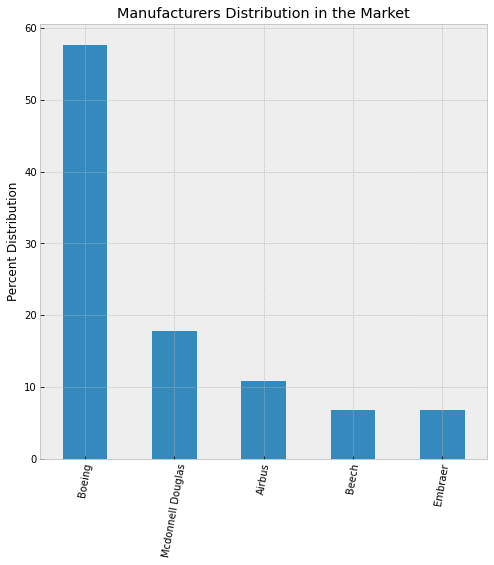

In [45]:
(aviation_cleaned['Manufacturer'].value_counts(normalize=True) * 100).plot(kind='bar', figsize=(8,8),
                            title='Manufacturers Distribution in the Market', ylabel= "Percent Distribution", rot=80);

Great! As expected with the data, Boeing makes up about 58% of the data. Let's look at total number of passengers per manufacturer and see if it lines up. 

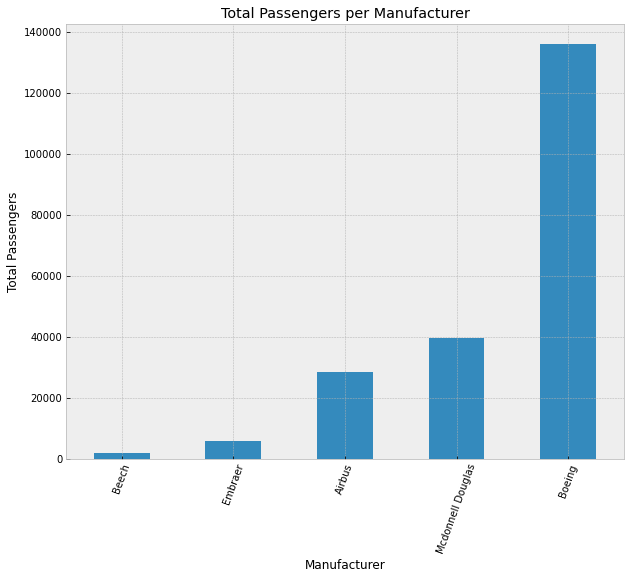

In [46]:
x=aviation_cleaned.groupby('Manufacturer')['Total.Passengers'].sum().sort_values().plot(kind='bar', figsize=(10,8), rot=70)

plt.xlabel('Manufacturer')
plt.ylabel('Total Passengers')
plt.title('Total Passengers per Manufacturer')
plt.show()

Yes, Boeing has the most number of passengers. This lines up. Let's look at the different injury levels per manufacturer. 

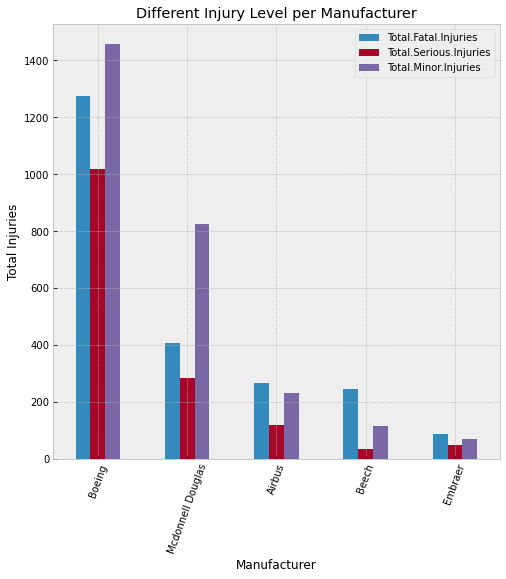

In [47]:
aviation_cleaned.groupby('Manufacturer')[['Total.Fatal.Injuries', 
                                          'Total.Serious.Injuries', 
                                          'Total.Minor.Injuries']].sum().sort_values(by='Total.Fatal.Injuries', 
                                                                                     ascending=False).plot(kind='bar', 
                                                                                                           figsize=(8,8), 
                                                                                                           title='Different Injury Level per Manufacturer', 
                                                                                                           ylabel='Total Injuries', 
                                                                                                           rot=70);


Here, I notice that Beech, Airbus, and Embrear tend to have more fatal injuries than serious or mild. Boeing and Mcdonnell Douglas seem to have more minor injuries than fatalities. 

Let's look at percentage of fatal/serious injuries per accident

In [48]:
manufacturer_injury_level = aviation_cleaned[['Total.Passengers','Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Manufacturer']].groupby('Manufacturer').sum()

In [49]:
manufacturer_injury_level['Fatal and Serious Percentage'] = ((manufacturer_injury_level['Total.Fatal.Injuries'] 
                                                             + manufacturer_injury_level['Total.Serious.Injuries']) 
                                                             / manufacturer_injury_level['Total.Passengers']) * 100

In [50]:
manufacturer_injury_level.head()

,Total.Passengers,Total.Fatal.Injuries,Total.Serious.Injuries,Fatal and Serious Percentage
Manufacturer,,,,
Airbus,28521.0,266.0,117.0,1.342870
Beech,1909.0,243.0,35.0,14.562598
Boeing,135788.0,1275.0,1018.0,1.688662
Embraer,5676.0,87.0,49.0,2.396054
Mcdonnell Douglas,39662.0,408.0,282.0,1.739700


Here, we see that per accident, Beech has the highest percentage of fatalities or serious injuries at 14% (inversely, it has the smallest percentage of minor or no injuries at 85%). 

#### Let's visualize it: 

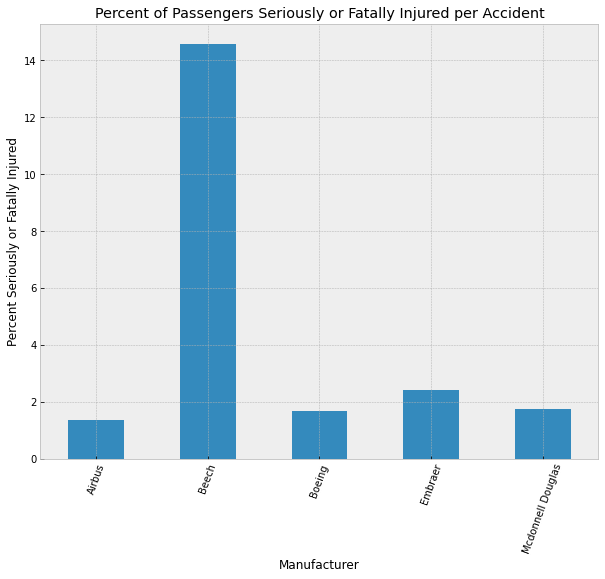

In [51]:
manufacturer_injury_level['Fatal and Serious Percentage'].plot(kind='bar', xlabel='Manufacturer', 
                                                               ylabel='Percent Seriously or Fatally Injured', 
                                                               title='Percent of Passengers Seriously or Fatally Injured per Accident',
                                                               figsize=(10,8), 
                                                              rot=70);

In [52]:
# ratio between seriously injured vs fatally injured
# sns barplot it will give you the error bars
#^compute fraction injured per accident (serious vs fatal, etc.), then instead of groupby agg, SNS barplot will plot as a fucntion of manufacturer
# x is manu, y is fraction injured per accident
# will do group by aggregation for you computes mean by default
# auto computes the 95% confidence level in estimateion of the mean
# see if the difference in a percent or so is meaningful
# then next plot, zoom in (just look at a few on a scale that is appropriate)

We can see here that flying on a Beech plane gives you the highest chance of sustaining a serious or fatal injury. Let's look at the inverse below. 

In [53]:
manufacturer_injury_level['Minor or Uninjured Percentage'] = 100 - manufacturer_injury_level['Fatal and Serious Percentage']

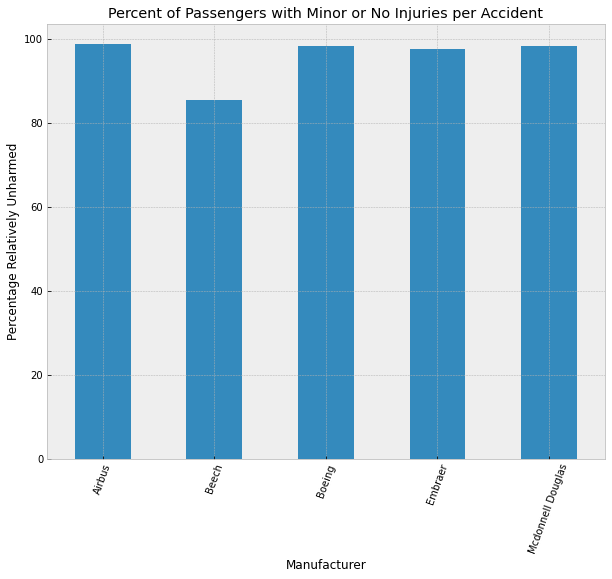

In [54]:
manufacturer_injury_level['Minor or Uninjured Percentage'].plot(kind='bar', xlabel='Manufacturer', 
                                                               ylabel='Percentage Relatively Unharmed', 
                                                               title='Percent of Passengers with Minor or No Injuries per Accident',
                                                               figsize=(10,8), 
                                                              rot=70);

Let's see if we can come up with an explanation as to why Beech has more severe injuries. Let's start with investigating the number of engines and engine type.

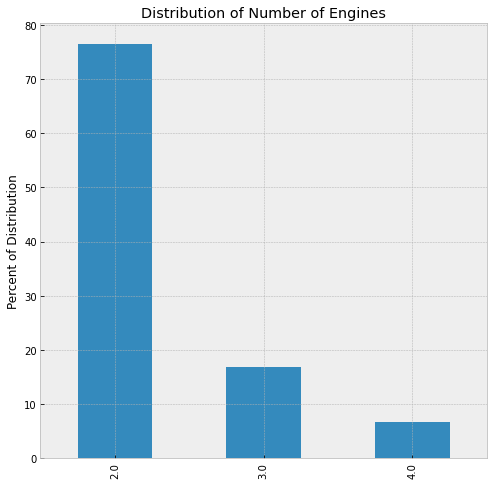

In [55]:
(aviation_cleaned['Number.of.Engines'].value_counts(normalize=True) * 100).plot(kind='bar', figsize=(8,8),
                            title='Distribution of Number of Engines', ylabel= "Percent of Distribution");

The market is made up mainly of 2 engine planes. Let's see what kind of engines they are.

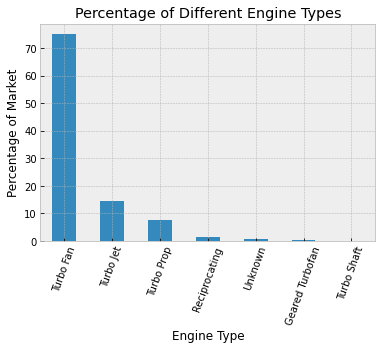

In [56]:
(aviation_cleaned['Engine.Type'].value_counts(normalize=True)*100).plot(kind="bar", 
                                                                        title=('Percentage of Different Engine Types'), 
                                                                        rot=70, xlabel=('Engine Type'), 
                                                                        ylabel='Percentage of Market');